In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import calendar
import seaborn as sns

import scipy.stats as stats
import pandas_profiling

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Data

In [2]:
customer_data = pd.read_excel("Datasets/CustomersData.xlsx")

In [3]:
online_sales = pd.read_csv("Datasets/Online_Sales.csv")

In [4]:
marketing_spend = pd.read_csv("Datasets/Marketing_Spend.csv")

In [5]:
disc_coupon = pd.read_csv("Datasets/Discount_Coupon.csv")

In [6]:
tax_amount = pd.read_excel("Datasets/Tax_amount.xlsx")

In [7]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB


In [8]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  int64  
 3   Date                 52924 non-null  object 
 4   Product_SKU          52924 non-null  object 
 5   Product_Description  52924 non-null  object 
 6   Product_Category     52924 non-null  object 
 7   Quantity             52924 non-null  int64  
 8   Avg_Price            52924 non-null  float64
 9   Delivery_Charges     52924 non-null  float64
 10  Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


In [9]:
marketing_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


In [10]:
# Lets make dates a datetime variable
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])

In [11]:
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])

In [12]:
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

In [13]:
disc_coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Month              204 non-null    object
 1   Product_Category   204 non-null    object
 2   Coupon_Code        204 non-null    object
 3   Discount_pct       204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB


In [14]:
tax_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Category  20 non-null     object 
 1   GST               20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 448.0+ bytes


In [15]:
# Are the unique customer ID Equal

In [16]:
online_sales.CustomerID.unique().shape

(1468,)

In [17]:
customer_data.CustomerID.count()

1468

# Data Preparation

## Joining the customer info and the online sales info in a new dataframe

In [18]:
sales_customer  = pd.merge(online_sales.set_index("CustomerID"),customer_data.set_index("CustomerID"),left_index=True,right_index=True).reset_index()


In [19]:
sales_customer.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Date',
       'Product_SKU', 'Product_Description', 'Product_Category', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months'],
      dtype='object')

In [20]:
sales_customer = sales_customer[['CustomerID','Gender', 'Location',
       'Tenure_Months', 'Transaction_ID', 'Transaction_Date',"Date",
       'Product_SKU', 'Product_Description', 'Product_Category', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status']]

In [21]:
sales_customer.Transaction_Date = pd.to_datetime(sales_customer.Date)

## Adding Dicount Coupon info

In [22]:
# There is a space Product_Category column name
disc_coupon.columns = ['Month', 'Product_Category', 'Coupon_Code', 'Discount_pct']

In [23]:
# Making a Month Column

In [24]:
import calendar
sales_customer["Month"]=sales_customer.Transaction_Date.dt.month.apply(lambda x:calendar.month_abbr[x])

In [25]:
sales_customer.drop("Date",axis=1,inplace=True)

In [26]:
sales_customer = pd.merge(sales_customer,disc_coupon,on=["Month","Product_Category"],how="left")

In [27]:
# Now we have added the necessory discount column in our data frame to to EDA

## Adding Tax Info

In [28]:
sales_customer = pd.merge(sales_customer,tax_amount,on="Product_Category",how="left")

In [29]:
sales_customer.to_csv("check.csv")

In [30]:
final_df = sales_customer.copy()

In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52924 entries, 0 to 52923
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  int64         
 1   Gender               52924 non-null  object        
 2   Location             52924 non-null  object        
 3   Tenure_Months        52924 non-null  int64         
 4   Transaction_ID       52924 non-null  int64         
 5   Transaction_Date     52924 non-null  datetime64[ns]
 6   Product_SKU          52924 non-null  object        
 7   Product_Description  52924 non-null  object        
 8   Product_Category     52924 non-null  object        
 9   Quantity             52924 non-null  int64         
 10  Avg_Price            52924 non-null  float64       
 11  Delivery_Charges     52924 non-null  float64       
 12  Coupon_Status        52924 non-null  object        
 13  Month                52924 non-

In [32]:
final_df.Discount_pct = final_df.Discount_pct/100
final_df.Discount_pct

0        0.3
1        0.3
2        0.3
3        0.3
4        0.3
        ... 
52919    0.1
52920    0.1
52921    0.1
52922    0.1
52923    0.1
Name: Discount_pct, Length: 52924, dtype: float64

In [33]:
# First lets fill nan with 0 to make calculations possible
# Where there is no discount is given 
final_df.fillna(0,inplace=True)

In [34]:
## Adding Invoice Value

In [35]:
## We can encode coupon status to be 0 for not used and clicked and 1 for used 
# It will also make calculations easy 
# just multiply with the coupon status encoded column to add or not add the discount percentage

### I have taken clicked to be such that it was not applied on the transaction

In [36]:
final_df.Coupon_Status.unique()

array(['Used', 'Clicked', 'Not Used'], dtype=object)

In [37]:
final_df["Invoice_Value"] = (final_df.Quantity*final_df.Avg_Price)*(1-final_df.Discount_pct*final_df.Coupon_Status.replace(['Used', 'Clicked','Not Used'],[1,0,0]))*(1+final_df.GST)+final_df.Delivery_Charges

In [38]:
final_df.to_csv("Final_DF.csv")

# EDA

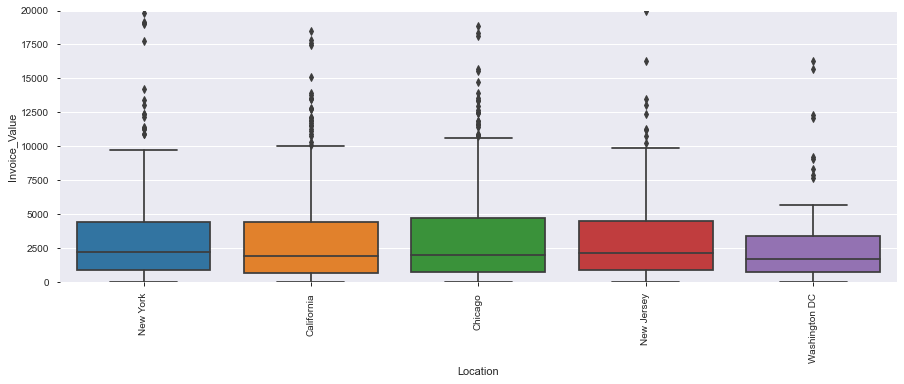

In [39]:
plt.figure(figsize=(15,5))
sns.boxplot(y = final_df.groupby("CustomerID")["Invoice_Value"].sum(),x=final_df.Location)
plt.ylim(0,20000)
plt.xticks(rotation=90)
plt.show()

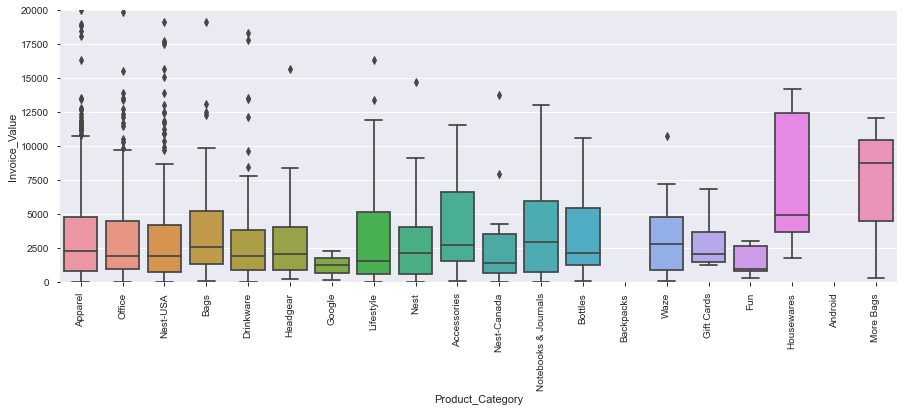

In [40]:
plt.figure(figsize=(15,5))
sns.boxplot(y = final_df.groupby("CustomerID")["Invoice_Value"].sum(),x=final_df.Product_Category)
plt.ylim(0,20000)
plt.xticks(rotation=90)
plt.show()

In [41]:
final_df.describe()

,CustomerID,Tenure_Months,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice_Value
count,52924.00000,52924.000000,52924.000000,52924.000000,52924.000000,52924.000000,52924.000000,52924.000000,52924.000000
mean,15346.70981,26.127995,32409.825675,4.497638,52.237646,10.517630,0.198024,0.137462,101.983198
std,1766.55602,13.478285,8648.668977,20.104711,64.006882,19.475613,0.082789,0.045825,172.365729
min,12346.00000,2.000000,16679.000000,1.000000,0.390000,0.000000,0.000000,0.050000,4.603500
25%,13869.00000,15.000000,25384.000000,1.000000,5.700000,6.000000,0.100000,0.100000,20.160000
50%,15311.00000,27.000000,32625.500000,1.000000,16.990000,6.000000,0.200000,0.180000,45.636200
75%,16996.25000,37.000000,39126.250000,2.000000,102.130000,6.500000,0.300000,0.180000,137.400000
max,18283.00000,50.000000,48497.000000,900.000000,355.740000,521.360000,0.300000,0.180000,8979.275000


In [42]:
### Best selling product is Nest Learning Thermostat 3rd Gen-USA - Stainless Steel. And it can be seen below

In [43]:
final_df.describe(include="object")

,Gender,Location,Product_SKU,Product_Description,Product_Category,Coupon_Status,Month,Coupon_Code
count,52924,52924,52924,52924,52924,52924,52924,52924
unique,2,5,1145,404,20,3,12,46
top,F,Chicago,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Apparel,Clicked,Aug,SALE20
freq,33007,18380,3511,3511,18126,26926,6150,6373


In [44]:
final_df.Product_Description.value_counts()[:5]

Nest Learning Thermostat 3rd Gen-USA - Stainless Steel    3511
Nest Cam Outdoor Security Camera - USA                    3328
Nest Cam Indoor Security Camera - USA                     3230
Google Sunglasses                                         1523
Nest Protect Smoke + CO White Battery Alarm-USA           1361
Name: Product_Description, dtype: int64

## Trend/Seasonality In Sales

#### Invoice_Value_Each_Month

In [45]:
final_df.groupby("Month")["Invoice_Value"].sum()

Month
Apr    477498.59102
Aug    475796.87554
Dec    556112.29179
Feb    375162.04730
Jan    494090.54875
Jul    451878.40904
Jun    361000.17429
Mar    415157.79044
May    365596.02956
Nov    547788.12626
Oct    480767.36981
Sep    396510.49254
Name: Invoice_Value, dtype: float64

In [46]:
# It would be worth poltting these Sales in Comparision with the perticular month marketing spend

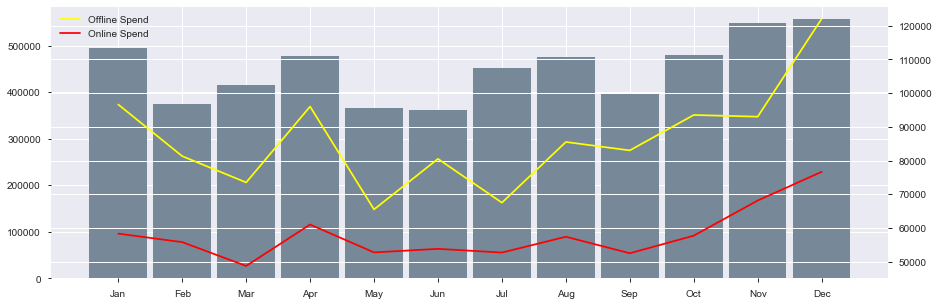

In [47]:
fig,ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()

bars = ax.bar(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],final_df.groupby("Month")["Invoice_Value"].sum().loc[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep"
                                                                   ,"Oct","Nov","Dec"]],width=.9,color='lightslategrey')
ax2.plot(marketing_spend.groupby("Month").sum()[["Offline_Spend"]].loc[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]],c="yellow",label="Offline Spend")
ax2.plot(marketing_spend.groupby("Month").sum()[["Online_Spend"]].loc[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]],c="red",label="Online Spend")

plt.legend()
plt.show()
#for bar in bars:
 #   plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+10, str(int(bar.get_height())), 
  #               ha='center', color='black', fontsize=11)
    
#plt.tick_params(top=False,left=False,bottom=False,right=False,labelleft=False,labelbottom="on")

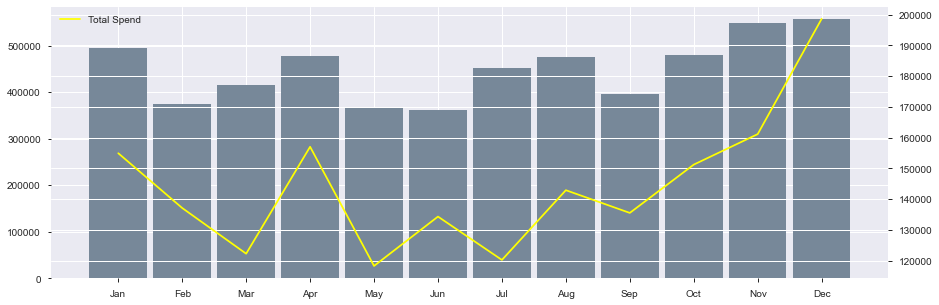

In [48]:
fig,ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()

bars = ax.bar(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],final_df.groupby("Month")["Invoice_Value"].sum().loc[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep"
                                                                   ,"Oct","Nov","Dec"]],width=.9,color='lightslategrey')
ax2.plot(marketing_spend.groupby("Month").sum()[["Total_Spend"]].loc[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]],c="yellow",label="Total Spend")


plt.legend()
plt.show()
#for bar in bars:
 #   plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+10, str(int(bar.get_height())), 
  #               ha='center', color='black', fontsize=11)
    
#plt.tick_params(top=False,left=False,bottom=False,right=False,labelleft=False,labelbottom="on")

## Cohort Analysis

In [49]:
# We have to find customers that are new in each month
# It means that there should be no transection befor that month for that customer

### DataFrame to work with cohort analysis

‘CohortMonth’ is the time when the customers made their first purchase

 ‘CohortIndex’ is the column where we get the difference between the first purchase and all the purchases that the customer made later.

‘groupby’ the customers by ‘CohortMonth’ and ‘CohortIndex’ so that we can identify the customers who came to purchase in the same month with the same interval

In [50]:
cohort_df = final_df.copy()

In [51]:
cohort_df["Cohort_Date"] = cohort_df.groupby("CustomerID")["Transaction_Date"].transform(min)

In [52]:
cohort_df["Cohort_Month"] = cohort_df["Cohort_Date"].dt.month

In [53]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    return year, month, date

Invoice_Year, Invoice_Month, _ = get_date_int(cohort_df, 'Transaction_Date')
Cohort_Year, Cohort_Month , _ = get_date_int(cohort_df, 'Cohort_Date')

Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month

cohort_df['Cohort_Index'] = Year_Diff*12 + Month_Diff +1

In [54]:
cohort_df.groupby("Cohort_Month").count()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value,Cohort_Date,Cohort_Index
Cohort_Month,,,,,,,,,,,,,,,,,,,,
1,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938
2,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214
3,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669
4,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015
5,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539
6,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754
7,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984
8,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691
9,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893


In [55]:
cohort_monthwise = cohort_df.pivot_table(values="CustomerID",index="Cohort_Month",columns="Cohort_Index",aggfunc=pd.Series.nunique)

In [56]:
cohort_monthwise.iloc[0]/cohort_monthwise.iloc[0].sum()

Cohort_Index
1     0.398148
2     0.024074
3     0.044444
4     0.062963
5     0.042593
6     0.081481
7     0.064815
8     0.087037
9     0.042593
10    0.051852
11    0.037037
12    0.062963
Name: 1, dtype: float64

In [57]:
cohort_monthwise["Total"] = pd.Series()

<ipython-input-57-fb70fb3287be>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cohort_monthwise["Total"] = pd.Series()


In [58]:
for i in range(12):
    cohort_monthwise["Total"].iloc[i]= cohort_monthwise.iloc[i].sum()

In [59]:
cohort_monthwise

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12,Total
Cohort_Month,,,,,,,,,,,,,
1,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0,540.0
2,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN,240.0
3,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN,398.0
4,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN,296.0
5,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN,191.0
6,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN,227.0
7,94.0,13.0,4.0,6.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,137.0
8,135.0,14.0,15.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0
9,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0


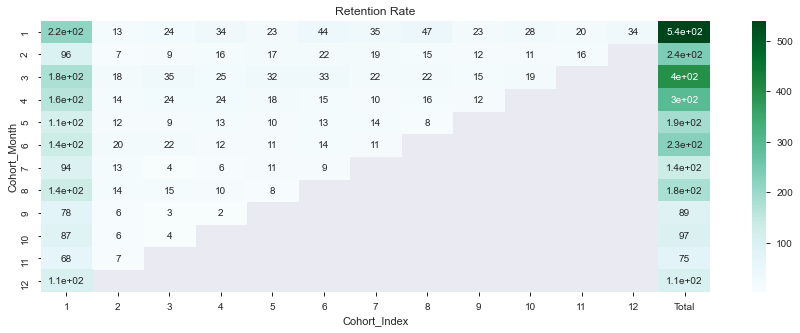

In [60]:
plt.figure(figsize=(15,5))
plt.title("Retention Rate")
sns.heatmap(data=cohort_monthwise,
           annot=True,
           cmap="BuGn"
           )
plt.show()

### Customers Added Each Month

In [61]:
customers_every_month = cohort_monthwise["Total"]

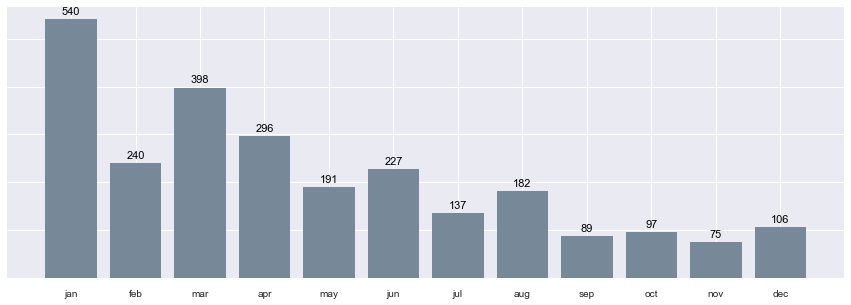

In [62]:
plt.figure(figsize=(15,5))
bars = plt.bar(["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"],customers_every_month,color="lightslategray")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+10, str(int(bar.get_height())), 
                 ha='center', color='black', fontsize=11)
    
plt.tick_params(top=False,left=False,bottom=False,right=False,labelleft=False,labelbottom="on")

### Cohort

In [63]:
for i in range(12):
    cohort_monthwise.iloc[i] = cohort_monthwise.iloc[i]/cohort_monthwise.iloc[i,:-1].sum()

In [64]:
cohort_monthwise

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12,Total
Cohort_Month,,,,,,,,,,,,,
1,0.398148,0.024074,0.044444,0.062963,0.042593,0.081481,0.064815,0.087037,0.042593,0.051852,0.037037,0.062963,1.0
2,0.400000,0.029167,0.037500,0.066667,0.070833,0.091667,0.079167,0.062500,0.050000,0.045833,0.066667,NaN,1.0
3,0.444724,0.045226,0.087940,0.062814,0.080402,0.082915,0.055276,0.055276,0.037688,0.047739,NaN,NaN,1.0
4,0.550676,0.047297,0.081081,0.081081,0.060811,0.050676,0.033784,0.054054,0.040541,NaN,NaN,NaN,1.0
5,0.586387,0.062827,0.047120,0.068063,0.052356,0.068063,0.073298,0.041885,NaN,NaN,NaN,NaN,1.0
6,0.603524,0.088106,0.096916,0.052863,0.048458,0.061674,0.048458,NaN,NaN,NaN,NaN,NaN,1.0
7,0.686131,0.094891,0.029197,0.043796,0.080292,0.065693,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,0.741758,0.076923,0.082418,0.054945,0.043956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,0.876404,0.067416,0.033708,0.022472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [65]:
cohort_monthwise = cohort_monthwise.round(2)*100

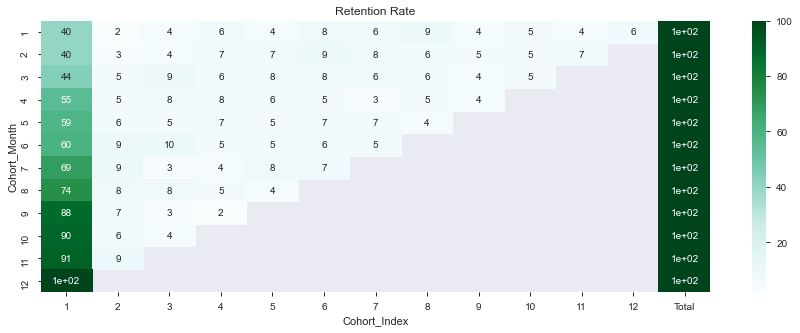

In [66]:
plt.figure(figsize=(15,5))
plt.title("Retention Rate")
sns.heatmap(data=cohort_monthwise,
           annot=True,
           cmap="BuGn"
           )
plt.show()

# Segmentation

## RFM

### Data Preparation

In [67]:
final_df.head()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value
0,12346,F,New York,31,38223,2019-09-15,GGOEAAAJ080816,Android Men's Engineer Short Sleeve Tee Charcoal,Apparel,1,19.99,75.00,Used,Sep,SALE30,0.3,0.18,91.51174
1,12346,F,New York,31,38223,2019-09-15,GGOEGOAR013099,Google Stylus Pen w/ LED Light,Office,2,5.50,75.00,Used,Sep,OFF30,0.3,0.10,83.47000
2,12347,M,New York,20,23979,2019-03-24,GGOEGOAQ020099,Four Color Retractable Pen,Office,1,2.99,14.41,Clicked,Mar,OFF30,0.3,0.10,17.69900
3,12347,M,New York,20,23979,2019-03-24,GGOEGOCT019199,Red Spiral Google Notebook,Office,1,9.99,14.41,Used,Mar,OFF30,0.3,0.10,22.10230
4,12347,M,New York,20,23980,2019-03-24,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,149.00,6.50,Used,Mar,ELEC30,0.3,0.10,121.23000


In [68]:
monetary = final_df.groupby("CustomerID")["Invoice_Value"].sum()

In [69]:
frequency = final_df.CustomerID.value_counts()

In [70]:
# For Recency we can use the last transection date 
date_last_trans = final_df.groupby("CustomerID")["Transaction_Date"].max()

In [71]:
# I've Choosed the date from which to countthe days of last transsaction to be 31/12/2019
recency = pd.datetime(2019,12,31)-date_last_trans

<ipython-input-71-bf5820c6fd2a>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  recency = pd.datetime(2019,12,31)-date_last_trans


In [72]:
CustomerID = monetary.index

In [73]:
# Lets make the dataframe

In [74]:
rfm_df = pd.DataFrame([CustomerID,recency,frequency,monetary]).T

In [75]:
rfm_df.columns = ["CustomerID","Recency","Frequency","Monetary"]

In [76]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  1468 non-null   object         
 1   Recency     1468 non-null   timedelta64[ns]
 2   Frequency   1468 non-null   object         
 3   Monetary    1468 non-null   object         
dtypes: object(3), timedelta64[ns](1)
memory usage: 46.0+ KB


### Parameter for the Segmentation

In [77]:
rfm_df.Frequency = rfm_df.Frequency.astype("int")

In [78]:
rfm_df.Monetary = rfm_df.Monetary.astype("int")

In [79]:
rfm_df.Recency = rfm_df.Recency.dt.days

In [80]:
rfm_df.quantile([.33,.67])

,Recency,Frequency,Monetary
0.33,78.00,13.0,1089.22
0.67,187.89,35.0,3489.56


### RFM Analysis

In [81]:
rfm_df["r_seg"] = np.where(rfm_df.Recency<=78,"Active",np.where(rfm_df.Recency<=187.9,"At Risk","Churn"))

In [82]:
rfm_df["f_seg"] = np.where(rfm_df.Frequency<=13,1,np.where(rfm_df.Frequency<=35,2,3))

In [83]:
rfm_df["m_seg"] = np.where(rfm_df.Monetary<=940.11,1,np.where(rfm_df.Monetary<=3034.78,2,3))

In [84]:
# Lets also make the fm_seg 
rfm_df["fm_seg"] = np.where((rfm_df.f_seg==3)&(rfm_df.m_seg==3),"Platinum",
                            np.where(((rfm_df.f_seg==3)&(rfm_df.m_seg==2))|((rfm_df.f_seg==2)&(rfm_df.m_seg==3)),"Gold",
                            np.where(((rfm_df.f_seg==2)&(rfm_df.m_seg==2))|((rfm_df.f_seg==1)&(rfm_df.m_seg==3))|((rfm_df.f_seg==3)&(rfm_df.m_seg==1)),"Silver","Standard")))

In [85]:
final_df.groupby("CustomerID").sum().reset_index()

,CustomerID,Tenure_Months,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice_Value
0,12346,62,76446,3,25.49,150.00,0.6,0.28,174.98174
1,12347,1200,1972760,342,3746.16,665.14,14.8,7.77,15686.84396
2,12348,897,774484,209,336.52,197.15,5.7,3.42,1689.55594
3,12350,425,796889,21,1312.40,127.88,5.1,2.16,1467.43528
4,12356,1116,1375803,56,1244.83,637.49,10.8,5.34,2007.42900
...,...,...,...,...,...,...,...,...,...
1463,18259,35,174149,46,84.73,278.33,0.6,1.13,860.68600
1464,18260,1720,1379321,141,1114.89,632.42,8.6,5.41,3016.54372
1465,18269,200,204995,10,89.34,51.50,1.0,1.36,166.90750
1466,18277,47,41388,2,149.00,6.00,0.1,0.10,333.80000


In [86]:
profiling = pd.merge(final_df.groupby("CustomerID").sum().reset_index(),rfm_df,on="CustomerID")

In [87]:
profiling_output = profiling[["Avg_Price","Delivery_Charges","Discount_pct","GST","Invoice_Value","Recency","Frequency","Monetary","r_seg","fm_seg"]].groupby(["r_seg","fm_seg"]).mean().T

In [88]:
profiling_output.to_csv("rfm_segmentation.csv")

In [89]:
profiling_output

r_seg                  Active                                         \
fm_seg                   Gold     Platinum       Silver     Standard   
Avg_Price         3544.035606  4293.554021  2892.282532   688.278738   
Delivery_Charges   675.965758   757.814742   458.165844   106.572621   
Discount_pct        12.210606    14.349485    10.088961     2.884466   
GST                  8.189318     9.220000     6.237662     1.749612   
Invoice_Value     6982.103922  8192.953024  5069.345065  1165.491055   
Recency             37.106061    33.525773    35.779221    34.533981   
Frequency           53.106061    81.288660    22.844156    12.000000   
Monetary          6981.606061  8192.422680  5068.805195  1164.961165   

r_seg                 At Risk                                        \
fm_seg                   Gold     Platinum       Silver    Standard   
Avg_Price         2218.936396  3327.856250  1552.262022  518.008231   
Delivery_Charges   500.490450   759.998750   317.876721  109.110136   
Discount_pct         9.856757    12.564286     6.678689    2.514966   
GST                  7.112703    10.187143     4.830000    1.847823   
Invoice_Value     4531.180565  7538.810118  2928.215077  916.946758   
Recency            130.693694   121.785714   130.666667  133.931973   
Frequency           58.162162    73.803571    43.994536   11.727891   
Monetary          4530.711712  7538.357143  2927.715847  916.489796   

r_seg                   Churn                                        
fm_seg                   Gold     Platinum       Silver    Standard  
Avg_Price         1921.422353  2494.145500  1412.410542  461.077919  
Delivery_Charges   445.844706   673.985500   347.991446  118.363401  
Discount_pct         7.075490    10.195000     5.351205    2.143147  
GST                  5.201078     7.090500     3.996386    1.561726  
Invoice_Value     4108.154915  5832.271868  2853.690796  888.837634  
Recency            274.333333   261.550000   266.644578  264.979695  
Frequency           41.068627    81.000000    29.825301   10.918782  
Monetary          4107.676471  5831.850000  2853.216867  888.299492

## Strategy

There can be applied three type of campaigns
1. Endorsement Programme: For the platinum customers having high frequency and high montary value some advertisement programmes can be operated.
2. Reactivation programmes: can be applied to those customers that have high monetary value but are in at risk category in the recency segment
3. Win Back Strategy: can be applies to those high monetary value customers that are churned or have large recency. So that their loyalty can be regained

## K-Means Algo

### Data Preparation

In [90]:
kmeans_df = final_df.copy()

In [91]:
# We will use codings for 1,2,3,4,5 for 'New York', 'California', 'Chicago', 'New Jersey', 'Washington DC' respectively
# Ands Male with 1 and female with 0 in gender
# In coupon status 1,2,0 for 'Used', 'Clicked', 'Not Used'
final_df.Location.unique()
final_df.Coupon_Status.unique()

# Since we will have to make dummy variables of all these categorical variables we should not add this product category column
# Lets have it! Don't ask me why.
#'Apparel', 'Office', 'Nest-USA', 'Bags', 'Drinkware', 'Headgear','Google', 'Lifestyle', 'Nest', 'Accessories', 'Nest-Canada',
#'Notebooks & Journals', 'Bottles', 'Backpacks', 'Waze',
#'Gift Cards', 'Fun', 'Housewares', 'Android', 'More Bags'
np.arange(0,20,1)

final_df.Product_Category.unique()

array(['Apparel', 'Office', 'Nest-USA', 'Bags', 'Drinkware', 'Headgear',
       'Google', 'Lifestyle', 'Nest', 'Accessories', 'Nest-Canada',
       'Notebooks & Journals', 'Bottles', 'Backpacks', 'Waze',
       'Gift Cards', 'Fun', 'Housewares', 'Android', 'More Bags'],
      dtype=object)

In [92]:
kmeans_df.Location = kmeans_df.Location.replace(['New York', 'California', 'Chicago', 'New Jersey', 'Washington DC'],[0,1,2,3,4])   
kmeans_df.Gender = kmeans_df.Gender.replace(["M","F"],[1,0]) 
kmeans_df.Coupon_Status = kmeans_df.Coupon_Status.replace(['Used', 'Clicked', 'Not Used'],[1,2,0]) 
kmeans_df.Product_Category = kmeans_df.Product_Category.replace(['Apparel', 'Office', 'Nest-USA', 'Bags', 'Drinkware', 'Headgear',
       'Google', 'Lifestyle', 'Nest', 'Accessories', 'Nest-Canada',
       'Notebooks & Journals', 'Bottles', 'Backpacks', 'Waze',
       'Gift Cards', 'Fun', 'Housewares', 'Android', 'More Bags'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]) 

In [93]:
# Columns to drop "Transaction_Date","Transaction_ID","Customer_ID","Product_SKU","Product_Description","Month"
kmeans_df.drop(["Transaction_Date","Transaction_ID","CustomerID","Product_SKU","Product_Description","Month","Coupon_Code"],axis=1,inplace=True)

In [94]:
# Have to make dummy of location, Coupon_Status and Product_Category
kmeans_df = pd.get_dummies(kmeans_df,columns=["Location","Coupon_Status","Product_Category"],drop_first=True,prefix=["Location",
                                                                                                                   "Coupon_Status",
                                                                                                                   "Product_Category"])

In [95]:
# There are no nan values 
# No need to treat them

In [96]:
# Outlier Treatment
def outlier_capping(x):
    x = x.clip(lower=x.quantile(.01),upper=x.quantile(.99))
    return x
kmeans_df = kmeans_df.apply(lambda x:outlier_capping(x))

In [97]:
# Some columns are just of 0 s only
# What does it means?
kmeans_df.Product_Category_7.unique()

array([0, 1], dtype=uint8)

### PCA

For Variable Reduction using Factor loadings

#### Standardization of the data

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA # Principal Component analusis (Variable Reduction)

In [99]:
sc = StandardScaler()

In [100]:
std_model = sc.fit(kmeans_df)

In [101]:
std_model.transform(kmeans_df)

array([[-0.7767995 ,  0.36147411, -0.30911652, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7767995 ,  0.36147411, -0.19181001, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28733348, -0.45466116, -0.30911652, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.7767995 ,  0.73244469, -0.19181001, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7767995 ,  0.73244469, -0.30911652, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7767995 ,  0.73244469, -0.30911652, ...,  0.        ,
         0.        ,  0.        ]])

In [102]:
kmeans_scaled = pd.DataFrame(std_model.transform(kmeans_df),columns=kmeans_df.columns)

In [103]:
kmeans_scaled.shape

(52924, 33)

In [104]:
kmeans_df.shape

(52924, 33)

In [105]:
pca_model = PCA(n_components=33)
pca_model = pca_model.fit(kmeans_scaled)

In [106]:
# eigen values of the PC vector
pca_model.explained_variance_

array([3.00305520e+00, 1.74767363e+00, 1.69183310e+00, 1.48808252e+00,
       1.37526524e+00, 1.16602393e+00, 1.14419316e+00, 1.12551068e+00,
       1.06971643e+00, 1.06134301e+00, 1.04286229e+00, 1.01888805e+00,
       1.00713493e+00, 9.85022822e-01, 9.46595376e-01, 9.26369169e-01,
       7.20985190e-01, 5.38734906e-01, 2.91201042e-01, 2.74077795e-01,
       2.22855326e-01, 1.08463738e-01, 4.45470648e-02, 2.31719460e-32,
       2.31719460e-32, 2.31719460e-32, 2.31719460e-32, 2.31719460e-32,
       2.31719460e-32, 2.31719460e-32, 2.31719460e-32, 2.31719460e-32,
       2.31719460e-32])

In [107]:
# It can be shown here that total of 10 PCs explain almost 80% of the variance in the data 
pca_model.explained_variance_ratio_.round(3)

array([0.131, 0.076, 0.074, 0.065, 0.06 , 0.051, 0.05 , 0.049, 0.047,
       0.046, 0.045, 0.044, 0.044, 0.043, 0.041, 0.04 , 0.031, 0.023,
       0.013, 0.012, 0.01 , 0.005, 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [108]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.13056515, 0.20654952, 0.2801061 , 0.34480411, 0.40459712,
       0.45529286, 0.50503945, 0.55397377, 0.6004823 , 0.64662678,
       0.69196776, 0.7362664 , 0.78005405, 0.82288032, 0.86403586,
       0.90431202, 0.93565861, 0.95908143, 0.9717421 , 0.9836583 ,
       0.99334748, 0.99806321, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [109]:
# We can directly use these PCs to fit our model 

In [110]:
# We canm have onlu 14 components that explain the most of variance in our data

In [111]:
pca_model = PCA(n_components=14)
pca_model = pca_model.fit(kmeans_scaled)

In [112]:
# This explains 78% percent of the variance
np.sum(pca_model.explained_variance_ratio_)

0.8228803203687134

In [113]:
# It gives an array lets transform these into a dataframe
pca_model.transform(kmeans_scaled)

array([[-1.379141  , -0.16159512,  2.69703194, ..., -0.02686708,
         0.6263534 ,  0.9909073 ],
       [-1.05965335,  0.62820965,  4.48746927, ...,  0.18421883,
         0.38466721,  0.67782055],
       [-0.768219  ,  1.57405227,  0.70186481, ...,  0.3390628 ,
         0.18069723, -0.32203   ],
       ...,
       [-1.15498743, -1.77484472,  0.15352928, ..., -0.47037778,
         0.6876317 , -0.36968909],
       [-1.32286534,  1.15010775, -0.64103245, ..., -0.44279747,
         0.78527902, -0.15710103],
       [-1.31969289,  1.15021123, -0.6409598 , ..., -0.44275771,
         0.78512667, -0.15684087]])

In [114]:
PCs = pd.DataFrame(pca_model.transform(kmeans_scaled),columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13","PC14"])

In [115]:
PCs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-1.379141,-0.161595,2.697032,0.095700,2.019488,-0.162646,0.827250,0.196918,0.258297,0.273530,0.103012,-0.026867,0.626353,0.990907
1,-1.059653,0.628210,4.487469,0.118321,0.031867,0.186137,0.594771,-0.043145,-0.604463,-0.678885,-0.021838,0.184219,0.384667,0.677821
2,-0.768219,1.574052,0.701865,0.027634,-2.084924,0.165443,-0.177102,0.530024,-0.990340,-1.020111,-0.136650,0.339063,0.180697,-0.322030
3,-0.805891,-0.917034,2.161712,-0.059130,-1.771314,0.170730,-0.144431,0.525229,-0.991959,-0.993548,-0.092718,0.340308,0.169130,-0.273278
4,2.135502,-1.952342,0.283964,-0.027250,0.293178,0.191068,-0.443282,0.200202,-0.382375,-0.167182,-0.134075,0.011793,0.601801,0.153558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,-1.322785,-1.829951,0.082381,-0.328160,-0.058414,2.705052,1.750475,-0.233366,0.115784,0.318964,0.138405,-0.465417,0.694364,-0.403498
52920,-1.241878,-1.840795,0.064450,-0.327899,-0.039717,2.702333,1.756407,-0.231487,0.113055,0.311549,0.137189,-0.464901,0.688391,-0.404899
52921,-1.154987,-1.774845,0.153529,-0.320946,0.061719,2.710141,1.762383,-0.231287,0.113582,0.302497,0.134956,-0.470378,0.687632,-0.369689
52922,-1.322865,1.150108,-0.641032,-0.195135,0.245283,2.692707,1.743576,-0.164362,0.289129,0.425486,0.138376,-0.442797,0.785279,-0.157101


In [116]:
loadings = pd.DataFrame((pca_model.components_.T*np.sqrt(pca_model.explained_variance_)).T,columns= kmeans_scaled.columns).T

In [117]:
loadings.columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13","PC14"]

In [118]:
loadings.to_csv("loadings1.csv")

In [119]:
kmeans_df.columns

Index(['Gender', 'Tenure_Months', 'Quantity', 'Avg_Price', 'Delivery_Charges',
       'Discount_pct', 'GST', 'Invoice_Value', 'Location_1', 'Location_2',
       'Location_3', 'Location_4', 'Coupon_Status_1', 'Coupon_Status_2',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Product_Category_4', 'Product_Category_5', 'Product_Category_6',
       'Product_Category_7', 'Product_Category_8', 'Product_Category_9',
       'Product_Category_10', 'Product_Category_11', 'Product_Category_12',
       'Product_Category_13', 'Product_Category_14', 'Product_Category_15',
       'Product_Category_16', 'Product_Category_17', 'Product_Category_18',
       'Product_Category_19'],
      dtype='object')

In [120]:
selected_vars = ["Tenure_Months","Quantity","Avg_Price","Delivery_Charges","Discount_pct","GST","Invoice_Value","Product_Category_8","Location_3"]

In [121]:
input_for_segmentation = kmeans_df[selected_vars]

### Model

#### Elbow Analysis

In [122]:
cluster_errors=[]
for cluster_num in range(2,12):
    model = KMeans(n_clusters=cluster_num,random_state=123) #state for centroids
    model = model.fit(input_for_segmentation)
    
    cluster_errors.append(model.inertia_)
df = pd.DataFrame({"num_clusters":range(2,12),"cluster_error":cluster_errors})

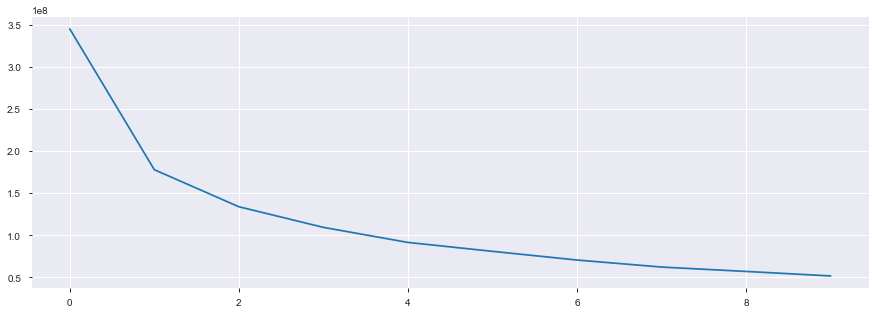

In [123]:
plt.figure(figsize=(15,5))
df.cluster_error.plot()
plt.show()

In [124]:
# It can be seen froom the curve that the inertia is is not increasing that rapidely after the 4 segments so we can take
# 4 or 5 segments for profiling the customers

In [125]:
km_3 = KMeans(n_clusters=3,random_state=123).fit(input_for_segmentation)
km_4 = KMeans(n_clusters=4,random_state=123).fit(input_for_segmentation)
km_5 = KMeans(n_clusters=5,random_state=123).fit(input_for_segmentation)
km_6 = KMeans(n_clusters=6,random_state=123).fit(input_for_segmentation)
km_7 = KMeans(n_clusters=7,random_state=123).fit(input_for_segmentation)
km_8 = KMeans(n_clusters=8,random_state=123).fit(input_for_segmentation)

In [126]:
## lets add thes to a dataframe to analyse them
profiling_df  = final_df.copy()

In [127]:
kmeans_df["cluster3"] = km_3.labels_
kmeans_df["cluster4"] = km_4.labels_
kmeans_df["cluster5"] = km_5.labels_
kmeans_df["cluster6"] = km_6.labels_
kmeans_df["cluster7"] = km_7.labels_
kmeans_df["cluster8"] = km_8.labels_

In [128]:
kmeans_df.cluster6.value_counts()

0    28805
3    10590
2     7095
1     3276
5     1853
4     1305
Name: cluster6, dtype: int64

### Profiling

In [129]:
profiling_output = pd.concat([kmeans_df.apply(np.mean).T,kmeans_df.groupby("cluster3").mean().T,kmeans_df.groupby("cluster4").mean().T,
kmeans_df.groupby("cluster5").mean().T,kmeans_df.groupby("cluster6").mean().T,kmeans_df.groupby("cluster7").mean().T,kmeans_df.groupby("cluster8").mean().T],axis=1)

In [130]:
size=pd.concat([pd.Series(kmeans_df.cluster3.size), pd.Series.sort_index(kmeans_df.cluster3.value_counts()), pd.Series.sort_index(kmeans_df.cluster4.value_counts()),
           pd.Series.sort_index(kmeans_df.cluster5.value_counts()), pd.Series.sort_index(kmeans_df.cluster6.value_counts()),
           pd.Series.sort_index(kmeans_df.cluster7.value_counts()), pd.Series.sort_index(kmeans_df.cluster8.value_counts())])

In [131]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/kmeans_df.cluster3.size, columns=['Seg_Pct'])

In [132]:
profiling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, profiling_output], axis=0)

In [133]:
profiling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [134]:
profiling_output_final.to_csv("profiling_output1.csv")

### Inference

We can use 6 segments of the customers
1. Label 1 and label 4 can be said to be premium customers the constitute 8% of the total customers and are good Quantity, Delivery_Charges, Average_Price and Invoice_Value. Actually their invoice value is way higher than the average invoice value. This implies that they are high revenue generating customers. If a person in this category has low retention then they can be enticed with advertisements. Label 4 Customes have very high Invoice_Value but they are also minimal in numbers only 2% of the customers

2. Here label 3 and label 5 Customers are good and similar in Average_Price and InvoiceValue and are bad performer in Delivery_Charges, Quantity and GST. They are 24% of the total number of customers. We can segment them as Gold customers because they are also the one that have higher Invoice_Value

3. label 2 customers are higher than average in quantity purchased and Delivery charges but have a average Invoice Value.

4. label 0 customers are the customers that can be called standard customers they are 54% of the total number of customers and are lower than average in Quantity, Average_Price and Invoice_Value


# Cross-Selling(Recommendation)

We will use Market Basket Analysis approach for Cross selling of products.

In [135]:
df_mba = final_df[["CustomerID","Product_Description","Quantity"]]

In [136]:
def check(x):
    if x>0:
        return 1
    else:
        return 0 
input_data = df_mba.pivot_table(columns = "Product_Description",index = "CustomerID",values="Quantity").fillna(0).applymap(check)

In [137]:
input_data.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12348,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model

In [138]:
frequent_itemset = apriori(input_data,use_colnames=True,min_support=0.07)

In [139]:
frequent_itemset.head()

,support,itemsets
0,0.076294,(1 oz Hand Sanitizer)
1,0.082425,(22 oz Android Bottle)
2,0.076975,(22 oz YouTube Bottle Infuser)
3,0.198910,(26 oz Double Wall Insulated Bottle)
4,0.153951,(8 pc Android Sticker Sheet)


## Rules

In [140]:
rules = association_rules(frequent_itemset,min_threshold=1,metric="lift")

In [141]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Nest Cam Indoor Security Camera - USA),(22 oz Android Bottle),0.649183,0.082425,0.074251,0.114376,1.387632,0.020742,1.036077
1,(22 oz Android Bottle),(Nest Cam Indoor Security Camera - USA),0.082425,0.649183,0.074251,0.900826,1.387632,0.020742,3.537409
2,(Nest Cam Outdoor Security Camera - USA),(22 oz Android Bottle),0.647139,0.082425,0.071526,0.110526,1.340931,0.018185,1.031593
3,(22 oz Android Bottle),(Nest Cam Outdoor Security Camera - USA),0.082425,0.647139,0.071526,0.867769,1.340931,0.018185,2.668512
4,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(22 oz Android Bottle),0.648501,0.082425,0.070163,0.108193,1.312626,0.016711,1.028894


In [142]:
# These are the items sets where there is a high to low confidence 
# Here confidence is the probability that the consequent is bought given that the antecedent is already bought
rules.sort_values(by='confidence', ascending=False )[:20]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
51510,"(Google Laptop and Cell Phone Stickers, Nest L...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.070163,0.648501,0.070163,1.0,1.542017,0.024662,inf
34973,"(Google Laptop and Cell Phone Stickers, Nest P...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.072888,0.648501,0.072888,1.0,1.542017,0.025620,inf
42744,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Cam Indoor Security Camera - USA),0.074932,0.649183,0.074932,1.0,1.540399,0.026287,inf
55417,"(Google Laptop and Cell Phone Stickers, Nest P...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.071526,0.648501,0.071526,1.0,1.542017,0.025141,inf
66233,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Indoor Security Camera - USA),0.075613,0.649183,0.075613,1.0,1.540399,0.026526,inf
41903,"(Nest Cam IQ - USA, Nest Protect Smoke + CO Wh...",(Nest Cam Indoor Security Camera - USA),0.071526,0.649183,0.071526,1.0,1.540399,0.025093,inf
41393,"(Nest Learning Thermostat 3rd Gen-USA - White,...",(Nest Cam Indoor Security Camera - USA),0.070845,0.649183,0.070845,1.0,1.540399,0.024854,inf
32304,"(Nest Cam Outdoor Security Camera - USA, Googl...",(Nest Cam Indoor Security Camera - USA),0.076975,0.649183,0.076975,1.0,1.540399,0.027004,inf
57650,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Indoor Security Camera - USA),0.080381,0.649183,0.080381,1.0,1.540399,0.028199,inf
20493,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Cam Indoor Security Camera - USA),0.091281,0.649183,0.091281,1.0,1.540399,0.032023,inf


In [143]:
# lets see the itemsets that have higher lift than 4 and they also have a high confidence 0f 0.8 or above
rules[ (rules['lift'] >= 4) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21464,"(Google Sunglasses, Nest Secure Alarm System S...","(Nest Cam Indoor Security Camera - USA, Nest T...",0.085831,0.194142,0.070163,0.817460,4.210638,0.053500,4.414702
21856,"(Google Sunglasses, Nest Secure Alarm System S...","(Nest Cam Outdoor Security Camera - USA, Nest ...",0.085831,0.185967,0.070845,0.825397,4.438398,0.054883,4.662187
22123,"(Google Sunglasses, Nest Secure Alarm System S...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.085831,0.201635,0.071526,0.833333,4.132883,0.054219,4.790191
23968,"(Nest Cam IQ - USA, Nest Secure Alarm System S...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.108311,0.201635,0.088556,0.817610,4.054904,0.066717,4.377243
25356,(Nest Protect Smoke + CO White Wired Alarm-USA...,"(Nest Cam Indoor Security Camera - USA, Nest T...",0.110354,0.194142,0.089237,0.808642,4.165216,0.067813,4.211260
...,...,...,...,...,...,...,...,...,...
67752,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.083787,0.201635,0.070163,0.837398,4.153043,0.053269,4.909946
67753,(Nest Protect Smoke + CO White Battery Alarm-U...,"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.085150,0.185967,0.070163,0.824000,4.430886,0.054328,4.625186
67758,(Nest Protect Smoke + CO White Battery Alarm-U...,"(Nest Cam Indoor Security Camera - USA, Nest T...",0.083787,0.194142,0.070163,0.837398,4.313336,0.053897,4.956029
67771,"(Nest Cam Indoor Security Camera - USA, Nest P...","(Nest Cam Outdoor Security Camera - USA, Nest ...",0.087193,0.173025,0.070163,0.804688,4.650714,0.055077,4.234114
